# Spectral Clustering


In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.


## Setup

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.getcwd()
os.chdir('/content/drive/MyDrive/MVA/GraphML')

In [3]:
!pip install networkx==2.8.8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!git clone https://github.com/graphsml/graphsexercises.git
!cd spectral_clustering
!pip install -r /content/drive/MyDrive/MVA/GraphML/requirements.txt

Cloning into 'graphsexercises'...
fatal: could not read Username for 'https://github.com': No such device or address
/bin/bash: line 0: cd: spectral_clustering: No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os

## Generating the data

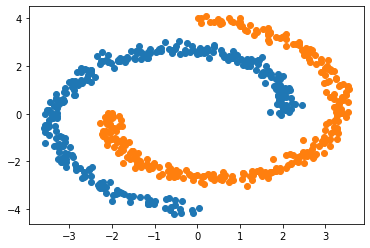

In [ ]:
# Example

for fn in [two_moons]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
worst_case_blob?

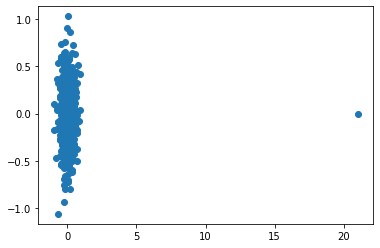

In [ ]:
for fn in [worst_case_blob]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600, delta=20)
    plot_clusters(X, Y, fignum=str(fn))

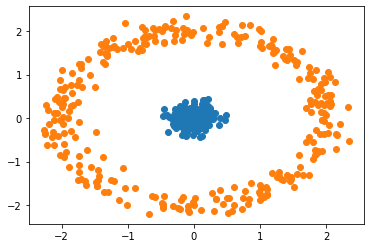

In [ ]:
for fn in [point_and_circle]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))

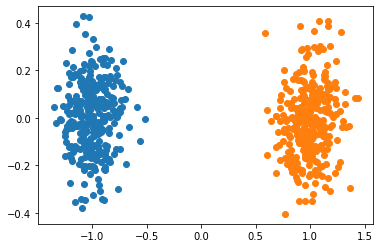

In [28]:
for fn in [blobs]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))

## Building similarity graph

In [6]:
import networkx as nx

In [12]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0):
    """
    TO BE COMPLETED.

    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """

    def distance_similarity(X,Y,var=1):
        return np.exp(-(X-Y).T.dot(X-Y)/(2*var))
  
    similarities = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
             similarities[i,j] = np.exp(-(X[i]-X[j]).T.dot(X[i]-X[j])/(2*var))

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        W = similarities*(similarities>=eps)

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        W = np.zeros((n,n))
        for i in range(n):
            dist_max_neigh = -np.sort(-similarities[i])[k] #we take the (k+1)th component and not the kth since the first is the node itself
            W[i] = similarities[i]*(similarities[i]>=dist_max_neigh)

    return W


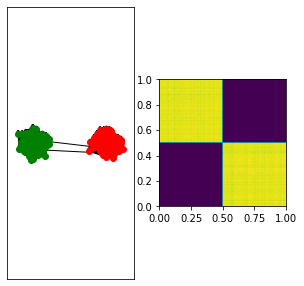

In [ ]:
# Example

W = build_similarity_graph(X, eps=0.75)
W[0, 599] = 1    # add two placeholder edges to reproduce example picture
W[10, 500] = 1   # 


plot_graph_matrix(X, Y, W)  # shows the graph and the visualization of W

## Computing the Laplacian

In [7]:
import scipy

In [13]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    L = np.zeros(W.shape)
    boolean_W = (W> 0)
    degrees = np.sum(boolean_W, axis=1)
    D = np.diag(degrees)
    if laplacian_normalization=='unn':
        L= D-W
    if laplacian_normalization=='sym':
        normW = np.diag(np.power(degrees, -0.5)) @ W @ np.diag(np.power(degrees, -0.5))
        L = np.eye(W.shape[0]) - normW
    if laplacian_normalization=='rw':
        normW = scipy.linalg.inv(D) @ W
        L = L = np.eye(W.shape[0]) - normW

    
    # for example (unnormalized): L = D - W
    return L

## Clustering

In [8]:
from scipy.sparse.linalg import eigs

In [14]:
def spectral_clustering(L, chosen_eig_indices=None, parameter_type='eps', num_classes=None):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    if chosen_eig_indices==None:
        G = nx.from_numpy_matrix(L)
        n_components = nx.number_connected_components(G)
        if n_components < num_classes :
            chosen_eig_indices = np.arange(n_components, num_classes)
        else :
            chosen_eig_indices = np.arange(1, num_classes)

    E, U  = scipy.linalg.eig(L)
    indices = np.argsort(E)
    E = E[indices]
    U = U[:,indices]
    U = U.real
    E = np.diag(E)
    U_cut = U[:,chosen_eig_indices]

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    km = KMeans(num_classes).fit(U_cut)
    Y = km.labels_
    return Y

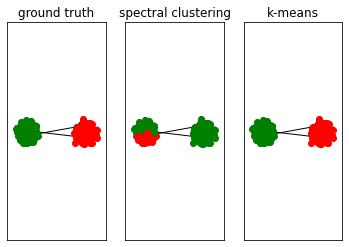

In [ ]:
# Example

num_classes = 2
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1, 2], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [15]:
def parameter_sensitivity(X, num_samples = 500, parameter_type='eps', laplacian_normalization = 'unn', chosen_eig_indices = None):
    """
    TO BE COMPLETED.

    A function to test spectral clustering sensitivity to parameter choice.
    """
    # the number of samples to generate
    #num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    #laplacian_normalization = 'unn'
    #chosen_eig_indices = None

    """
    Choose candidate parameters
    """

    X, Y = two_moons(num_samples, 1, 0.02)
    num_classes = len(np.unique(Y))

    if parameter_type == 'eps':
        parameter_candidate = np.linspace(0, 1, 20)
        eps_optimal = get_epsilon(X)
        print('The epsilon corresponding to a 1 connected component is : ', eps_optimal)
        
    else :
        parameter_candidate = np.arange(0, 100, 5)
    #parameter_candidate = [1, 2]  # the number of neighbours for the graph (if 'k')
                                  # or the epsilon threshold (if 'eps')
    parameter_performance = []

    for parameter in parameter_candidate:
        # Generate data
        parameter_wrap = {parameter_type: parameter}
        
        W = build_similarity_graph(X, **parameter_wrap)
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]

    plt.figure()
    plt.plot(parameter_candidate, parameter_performance)
    if parameter_type=='eps':
        plt.axvline(eps_optimal, color='green', linestyle='--')
    plt.title(f'parameter sensitivity ({parameter_type})')
    plt.show()

## Image segmentation

In [9]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

In [16]:
def image_segmentation(input_img='four_elements.bmp', parameter_type='k', var=0.7, num_classes=5, eps=None, metric='euclidean'):
    """
    TO BE COMPLETED

    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    #k = 2
    laplacian_normalization = 'rw'
    if parameter_type =='eps':
        chosen_eig_indices = [i for i in range(1,num_classes)]
        if eps==None:
            eps = get_epsilon(Xr)
        W = build_similarity_graph(Xr, var=var, eps=eps)
        L = build_laplacian(W, laplacian_normalization)
    elif parameter_type=='k':
        best_score = 0
        k_chosen = 0
        W_chosen = np.zeros((Xr.shape[0], Xr.shape[0]))
        for k in range(5,81,5):
            pair_dist = pairwise_distances(Xr)
            W = build_similarity_graph(Xr, var=var, k=k)
            L = build_laplacian(W, laplacian_normalization)
            chosen_eig_indices = [i for i in range(1,num_classes)]
            E, U =scipy.linalg.eig(L)
            indices = np.argsort(E)
            U = U[:,indices]
            U = U[:,chosen_eig_indices]
            U = np.real(U)
            kmeans = KMeans(num_classes).fit(U)
            score = silhouette_score(Xr, kmeans.labels_, metric=metric)
            if score > best_score :
                best_score = score
                k_chosen = k
                W_chosen = W
        L = build_laplacian(W, laplacian_normalization)  
        print('The chosen k is : ', k_chosen)

    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

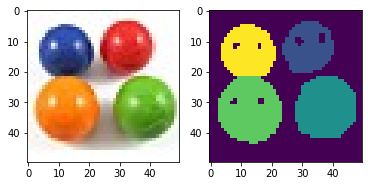

In [ ]:
image_segmentation(parameter_type='eps', var=0.7, num_classes=5)

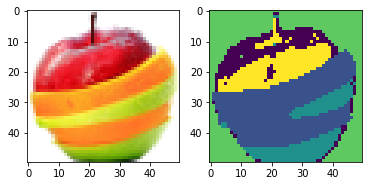

In [ ]:
image_segmentation('fruit_salad.bmp', parameter_type='eps', var=0.7, num_classes=5)

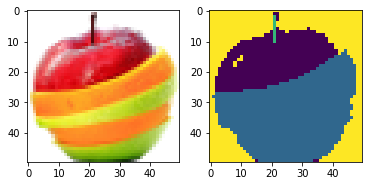

In [20]:
image_segmentation('fruit_salad.bmp', parameter_type='eps', var=0.7, num_classes=4)

The chosen k is :  50


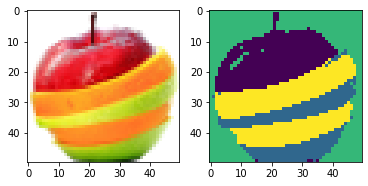

In [16]:
image_segmentation('fruit_salad.bmp', parameter_type='k', var=1, num_classes=4)

The chosen k is :  65


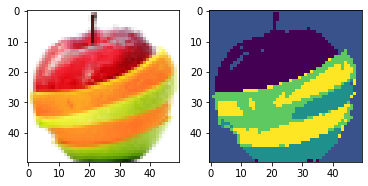

In [19]:
image_segmentation('fruit_salad.bmp', parameter_type='k', var=1, num_classes=5)

The chosen k is :  55


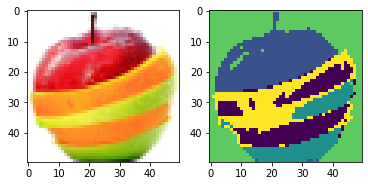

In [41]:
image_segmentation('fruit_salad.bmp', parameter_type='k', var=1, num_classes=5, metric='mahalanobis')

The chosen k is :  65


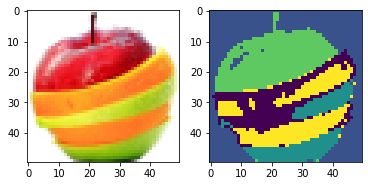

In [18]:
image_segmentation('fruit_salad.bmp', parameter_type='k', var=0.8, num_classes=5)

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

The function worst_case_blob enables to generate a blob with an outlier. The parameter 'delta' enables to decide how far the outlier is from the original blob. This will be useful to see whether our algorithms are robust to these outliers. It also enables to generate several clusters from several distances from the original blob.

<Figure size 432x288 with 0 Axes>

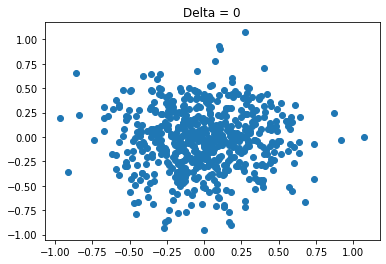

<Figure size 432x288 with 0 Axes>

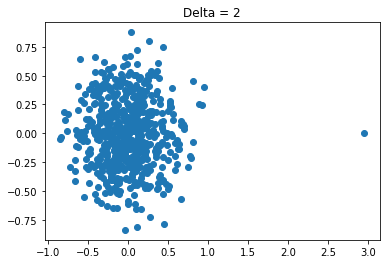

<Figure size 432x288 with 0 Axes>

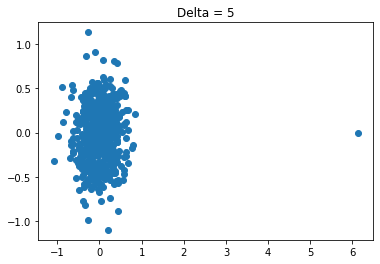

In [17]:
for delta in [0,2,5]:
    X, Y = worst_case_blob(num_samples=600, delta=delta)
    plt.figure()
    plot_clusters(X, Y, fignum=str(worst_case_blob))
    plt.title('Delta = {}'.format(delta))
    plt.show()

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

To select a value of $\epsilon$ that keeps the graph connected, we take the value as the minimal distance in the maximum spanning tree of the graph. Indeed, this will ensure that the outlier remains connected with the main blob. To do that, we compute the minimum spanning tree over the opposite of the weight matrix in order to keep only the longest edges in the tree and then, we take the smallest value of distance in the weight matrix of the tree, which is our $\epsilon$.

We can see below that when $\delta = 0$, ie there is no outlier, there is no problem with the approach since the graph remains connected and even if we take a high value of epsilon (near 1.), the graph remains connected. But when $\delta \in [1,5]$ (there is an outlier close to the blob), the outlier is connected to the blob by only one edge. We can see that it represents an effort since suddenly the value of epsilon is very low, close to 0. Finally when $\delta > 6$, the outlier cannot be connected from the graph, and the value of epsilon is then as in the case of $\delta=0$, and we consider the blob and its outlier as two distinct clusters. Indeed, we cannot lower the value of epsilon more than we done for $\delta=5$ and to keep a connected graph, we should put $\epsilon=0$ but then the graph would not be a tree anymore and we would need to deal with a huge amount of edges.

So, this approach is not very good when there is outliers since it imposes a huge constraint on the epsilon value to keep a graph connected and it does not work anymore when the outlier is too far : it considers the connected graph as only the blob without the outlier.

In [17]:
def get_epsilon(X):
    "put the value of eps equal to the maximum distance on the minimum spanning tree"
    W_eps = build_similarity_graph(X)
    X_mst = min_span_tree(-W_eps)
    eps = np.min(W_eps[X_mst])
    return eps

For δ = 0 and ϵ = 0.9640348087251244 :


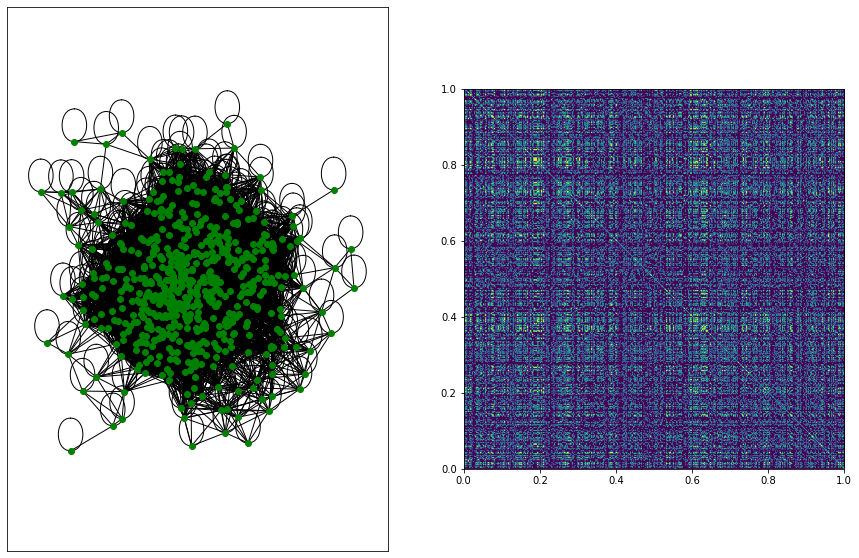

For δ = 2 and ϵ = 0.13072780696823533 :


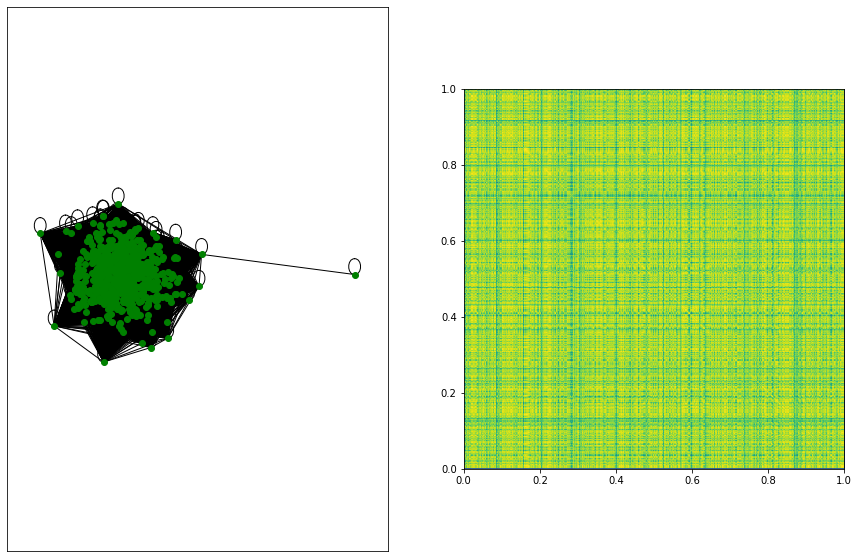

For δ = 5 and ϵ = 3.4380226341499334e-06 :


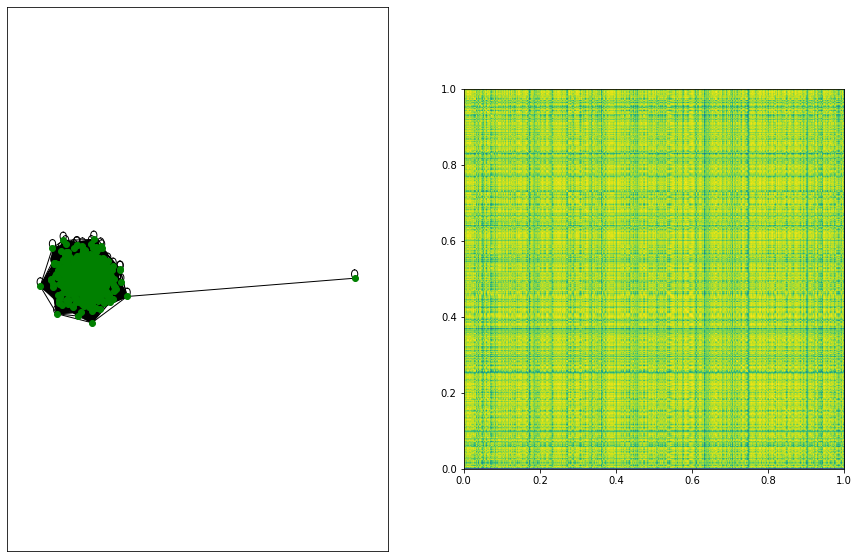

For δ = 6 and ϵ = 0.9763442565184368 :


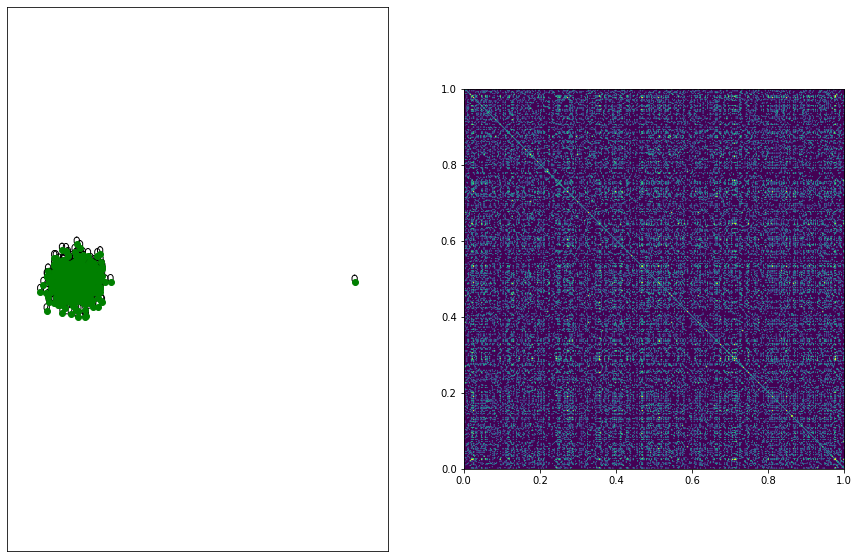

For δ = 7 and ϵ = 0.958486006988683 :


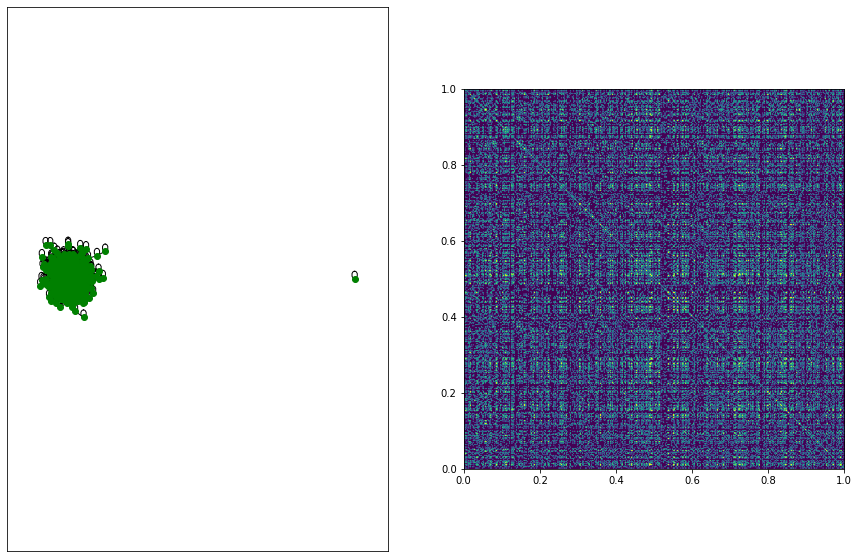

For δ = 10 and ϵ = 0.9579274858100819 :


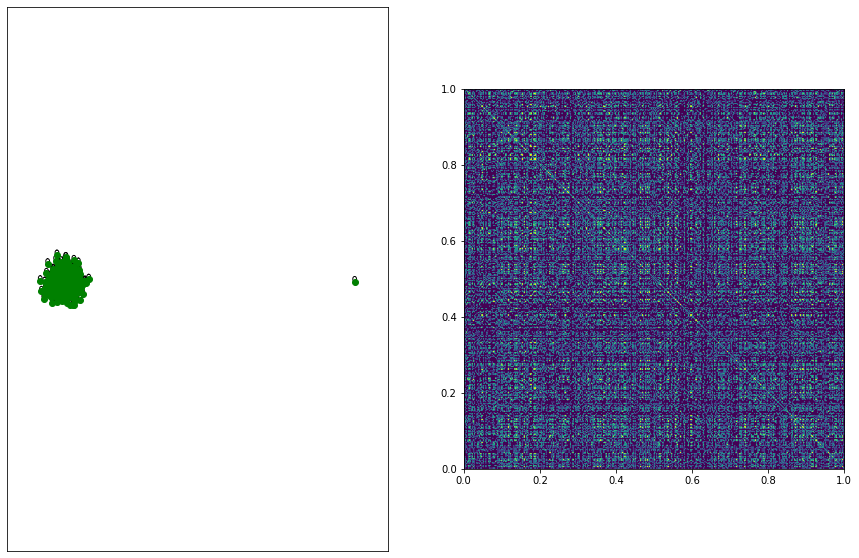

In [ ]:
for delta in [0,2,5,6,7,10]:
    X, Y = worst_case_blob(num_samples=600, delta=delta)
    eps = get_epsilon(X)
    print('For δ = {} and ϵ = {} :'.format(delta, eps))
    W = build_similarity_graph(X, eps=eps)
    plot_graph_matrix(X, Y, W, figsize=(15,10))

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

It is important to build a connected graph since we want to apply the spectral clustering algorithm. With disconnected components, it would not always be possible to compute the Laplacian matrix in the case of symmetric or random walk Laplacian matrix and with nodes that are not considered connected to themselves.

Moreover, since we want the algorithm to separate the dataset into clusters, if we have two components in the graph that are not connected, the algorithm will return clusters corresponding to these components, so it could lead to inaccurate results. It is better to apply clustering methods over a global connected component.

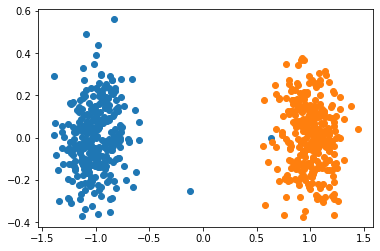

In [19]:
X_blobs, Y_blobs = blobs(n_blobs =2, num_samples=600)
X_outlier, Y_outlier = worst_case_blob(num_samples=2, delta=0.5)
X = np.vstack((X_blobs, X_outlier))
Y = np.hstack((Y_blobs, Y_outlier))
plot_clusters(X, Y, fignum='blobs')

For blob_var = 0.1 and ϵ = 0.41017397377318154 :


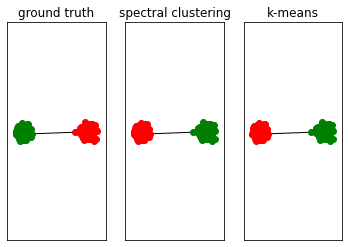

For blob_var = 1 and ϵ = 0.5479142473540394 :


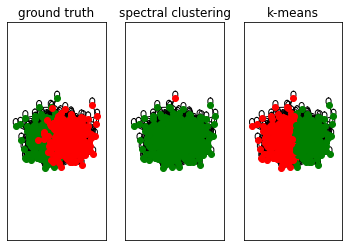

In [35]:
num_classes = 2

for delta in [0.1, 1]:
    X, Y = blobs(n_blobs = 2, num_samples=600, blob_var=delta)
    eps = get_epsilon(X)
    print('For blob_var = {} and ϵ = {} :'.format(delta, eps))
    W = build_similarity_graph(X, eps=eps)
    L = build_laplacian(W, 'unn')
    Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)
    plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

In [36]:
def choose_k(X, Y, step = 5):
    k = step
    W = build_similarity_graph(X, k=k)
    G = nx.from_numpy_matrix(W)
    n_components = nx.number_connected_components(G)
    while n_components != 1 and k < len(X):
        k += step
        W = build_similarity_graph(X, k=k)
        G = nx.from_numpy_matrix(W)
        n_components = nx.number_connected_components(G)
    if n_components==1:
        return k
    else :
      raise 'Error : we cannot find a connected graph between {} and {}'.format(step, k_max)

For blob_var = 0.1 and k = 300 :


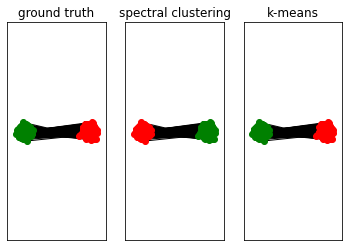

For blob_var = 1 and k = 5 :


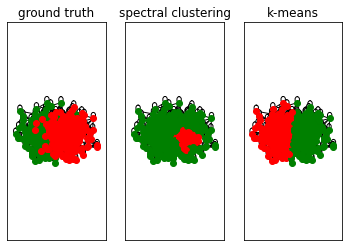

In [38]:
for delta in [0.1, 1]:
    X, Y = blobs(n_blobs=2, num_samples=600, blob_var=delta)
    k_chosen = choose_k(X,Y)
    print('For blob_var = {} and k = {} :'.format(delta, k_chosen))
    W = build_similarity_graph(X, k=k_chosen)
    L = build_laplacian(W, 'unn')
    Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)
    plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

Getting an connected graph with $\epsilon$-graphs is much easier than using KNN-graphs because we get a deterministic way of finding an $\epsilon$ thanks to the mininimum spanning tree algorithm that provides a connected graph anytime. This is more difficult with KNN-graphs since it depends a lot of the repartition of data. 

Indeed, above, obtaining a connected graph with a variance of each blob equal to 0.1 is much more difficult than when it is 1. Indeed, if the two clusters are too far apart and have a low variance, we have to take k equal to the number of points in the cluster plus one to be able to connect the two clusters. If we don't know a priori how the dataset is distributed, looking for k can be very expensive computationally and furthermore, the resulting graph can be heavy in terms of number of edges.

### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

The objective function of spectral clustering problem is, according to the Relaxed Balanced Cuts problem :
$$\min_{f} f^TLf \mbox{  s.t.  } f\in \mathbb{R}, f\perp\mathbb{1}_N, ||f||=\sqrt{N}$$

$L$ has $N$ eigenvalues and its minimal eigenvalue is $0$ associated with the eigenvector $\mathbb{1}_N$. As $0$ is of multiplicity the number of connected components and as we are considering a connected graph (so only one connected component), the multiplicity of $0$ is $1$. So the objective function in this case is the second eigenvector.

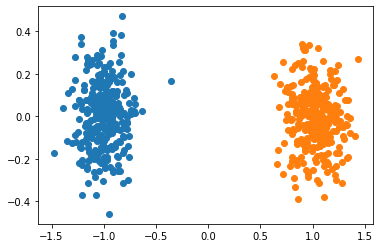

In [ ]:
X, Y = blobs(num_samples=600)
plot_clusters(X, Y)

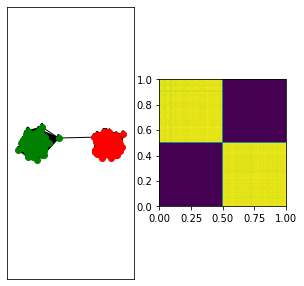

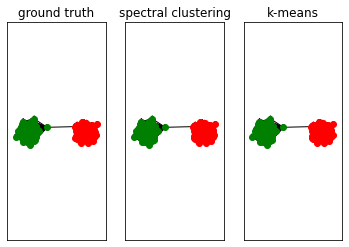

In [ ]:
num_classes = 2

eps = get_epsilon(X)
W = build_similarity_graph(X, eps=eps)
plot_graph_matrix(X, Y, W) 
L = build_laplacian(W, 'unn')
Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

We can see from the previous results that in the plot of the edges and nodes, the two blobs are well connected and that in the weight matrix there are two connected components even id the matrix must not be exactly in 2-blocks separated, since there is an edge between the two blobs.

We can see that the result of the sepectral clustering is consistent with the ground truth and that k-means give also the same result.

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

Since there are two separated components, the multiplicity of $0$ is $2$. So this is the third eigenvector which solve the Relaxed Balanced Cut problem (and which is the objective function).

To get two separated components, we need to adapt a little a bit our choice of epsilon : we need to take the second smallest distance in the maximum spanning tree, to drop out the edge between the two blobs.

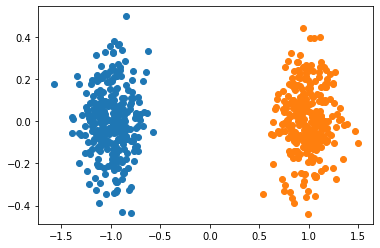

In [ ]:
X, Y = blobs(num_samples=600)
plot_clusters(X, Y)

In [ ]:
def get_epsilon_2_components(X):
    "put the value of eps equal to the maximum distance on the minimum spanning tree"
    W_eps = build_similarity_graph(X)
    X_mst = min_span_tree(-W_eps)
    components = np.sort(W_eps[X_mst])
    eps = components[1]
    return eps

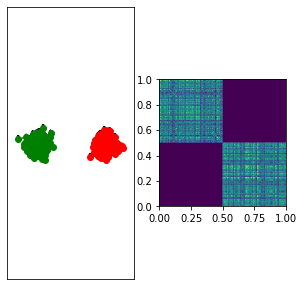

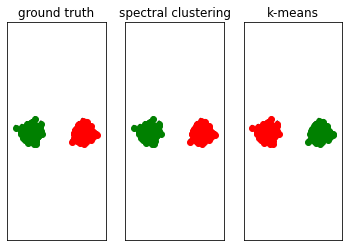

In [ ]:
num_classes = 2

eps = get_epsilon_2_components(X)
W = build_similarity_graph(X, eps=eps)
plot_graph_matrix(X, Y, W) 
L = build_laplacian(W, 'unn')
Y_rec = spectral_clustering(L, chosen_eig_indices=[2], num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

We can see in the plot of the nodes and edges that the two blobs are disconnected but that each blob is intra-connected, as we can see in the weight matrix where there are 2 blocks.

In this configuration, we can see that the result of spectral clustering is still consistent with the ground truth, as well K-means result.

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

After several trials, we could clearly see that taking only 1 eigenvector was not satisfying at all with several blobs. Indeed, it is a bit difficult to well classify the dataset in 4 clusters with only 1 feature.

With more than two clusters, the optimization problem of spectral clustering is not the same anymore. For $K >2$, the Cut function is more complicated and can be written as :
$$Cut(\mathcal{C}_1,..., \mathcal{C}_K) = \sum_{i=1}^N \sum_{j=1}^N \sum_{k=1}^K \mathbb{1}_{i \in \mathcal{I}_k, j \in \bar{\mathcal{I}_k}} w_{i,j}$$
where $\mathcal{I}_k$ is the set of indices for which the corresponding nodes are in $\mathcal{C}_k$ and $\bar{\mathcal{I}_k}$ the complementary of $\mathcal{I}_k$.

We can rewrite the cut function as :
$$Cut(\mathcal{C}_1,..., \mathcal{C}_K) = P^TW(I-P)$$
where $P_{i,j} = \mathbb{1}_{i \in \mathcal{I}_j}$ and $P \in \mathbb{R}^{N\times K}$. 

In several papers and especially in *A Tutorial in Spectral Clustering* by Ulrike von Luxburg and *On Spectral Clustering:
Analysis and an algorithm* by A.Y.Ng, M.I.Jordan and Y.Weiss, it is shown that the solution of this problem, for $k > 2$ clusters, is the $k$ first eigenvectors. So this is what I used to choose my eigenvectors in the following code.

To choose properly which eigenvector to use, we need to compute in the spectral_clustering function how many connected components there are in the graph, to avoid to take into account a eigenvector which is associated with the eigenvalue $0$. But in practice, especially in the case where we use $\epsilon$-graphs and compute the epsilon via the minimum spanning tree, there is only one component.

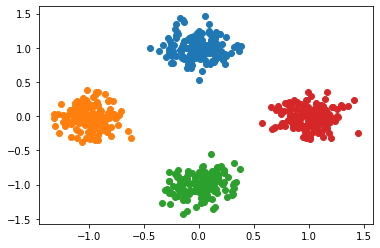

In [ ]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
plot_clusters(X, Y)

For blob_var = 0.15 :


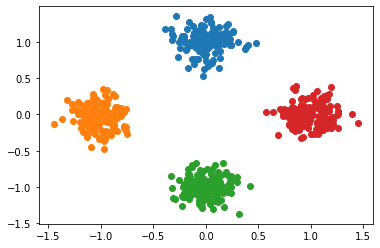

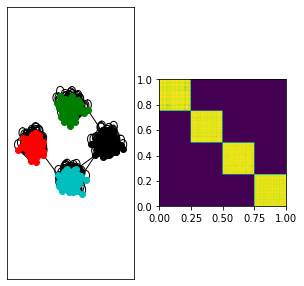

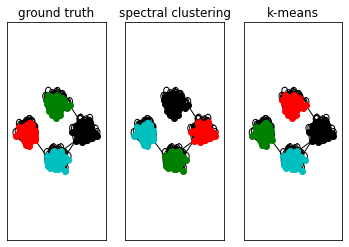

For blob_var = 0.2 :


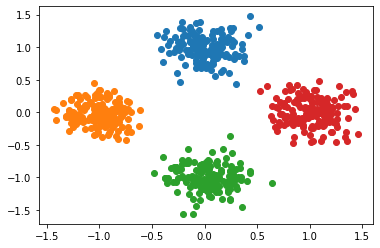

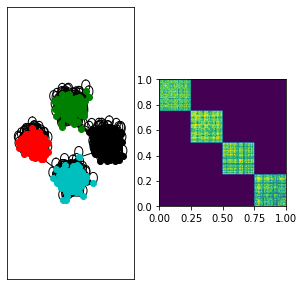

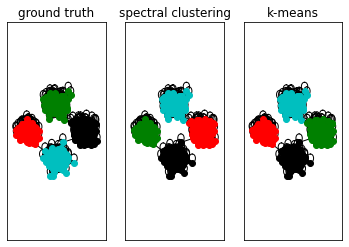

For blob_var = 0.5 :


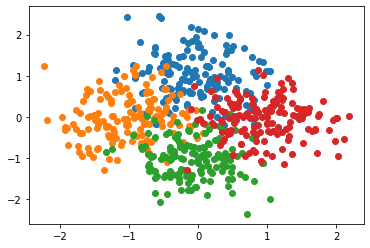

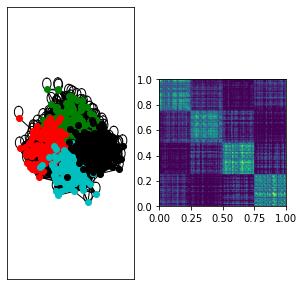

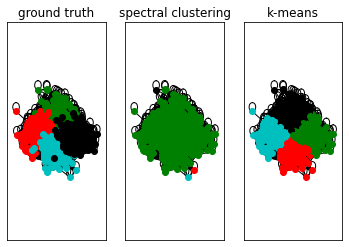

In [ ]:
num_classes = 4
for var in [0.15, 0.2, 0.5]:
    print('For blob_var = {} :'.format(var))
    X, Y = blobs(num_samples=600, n_blobs=4, blob_var=var)
    plot_clusters(X, Y)
    eps = get_epsilon(X)
    W = build_similarity_graph(X, eps=eps)
    plot_graph_matrix(X, Y, W) 
    L = build_laplacian(W, 'unn')
    Y_rec = spectral_clustering(L, num_classes=num_classes)
    plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

We can see on the results, that when the blob variance is not too big, ie when the blobs are well separated, the spectral clustering performs well but as soon as the blobs are no longer linearly separable, the method no longer works.

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

When I built the cluster assignment, I used the thresholding method because I always had the number $k$ of clusters specified. So, I could keep among the first $k$ eigenvectors, those corresponding to a non-zero eigenvalue.

But in the case when the number of clusters is not known like in image segmentation, I would add the option by default of chosing the eigenvectors by k-means method.

The main advantage of thresholding is that it is faster and simpler but k-means can also help when there is additional fine-tuning that is needed, because of the charasteristics of the data.

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

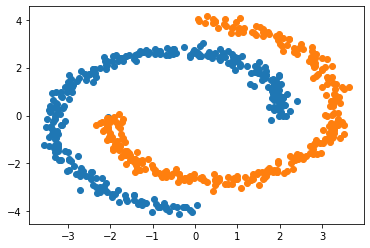

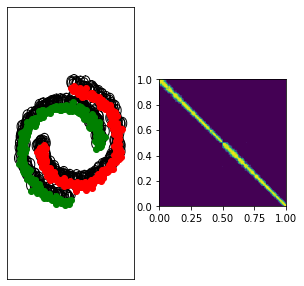

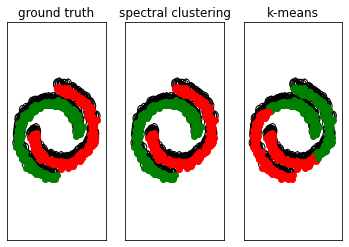

In [ ]:
num_classes = 2

X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)
eps = get_epsilon(X)
W = build_similarity_graph(X, eps=eps)
plot_graph_matrix(X, Y, W) 
L = build_laplacian(W, 'sym')
Y_rec = spectral_clustering(L, num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

We can see that the result with spectral clustering is exactly the same as the ground truth, while K-means did not give the good result at all. This shows that spectral clustering do not need to have convex clusters to be accurate while k-means algorithm by construction will agregate points around the barycenters of the clusters that it found.

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

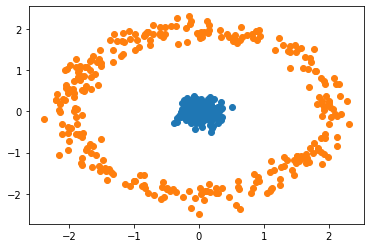

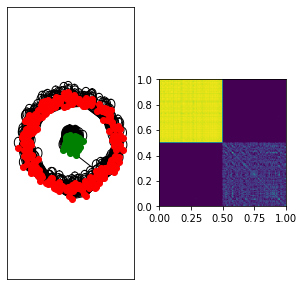

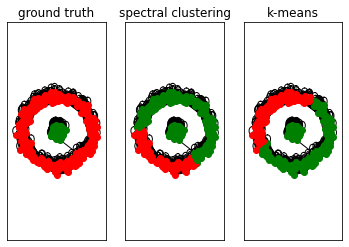

In [ ]:
num_classes = 2

X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)
eps = get_epsilon(X)
W = build_similarity_graph(X, eps=eps)
plot_graph_matrix(X, Y, W) 
L = build_laplacian(W, 'unn')
Y_rec = spectral_clustering(L, num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

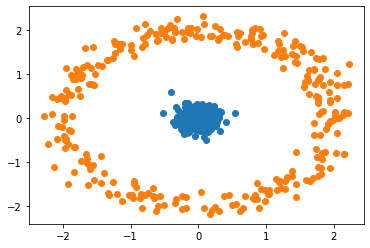

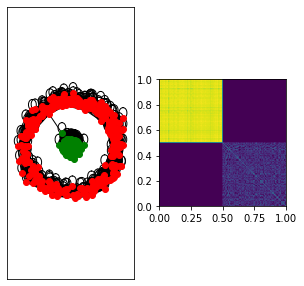

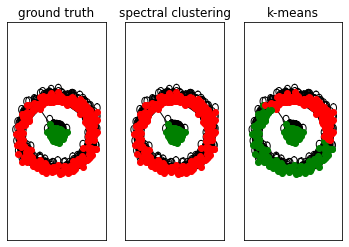

In [ ]:
num_classes = 2

X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)
eps = get_epsilon(X)
W = build_similarity_graph(X, eps=eps)
plot_graph_matrix(X, Y, W) 
L = build_laplacian(W, 'rw')
Y_rec = spectral_clustering(L, num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

We can see that with the normal Laplacian, the results of spectral clustering is as poor as the one of K-Means. It does not manage to find the two clusters that are nested.

With the random walk regularized Laplacian, we can see that the result of spectral clustering is the same as ground truth.

This can be explained by the fact that the random walk is a stochastic process which explore more nodes and the fact that the stationnary distribution is defined with respect to the volume of the cluster, while in the normal Laplacian, the optimization problem is to maximize the cardinality of each cluster.

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

The epsilon corresponding to a 1 connected component is :  0.840733622255361


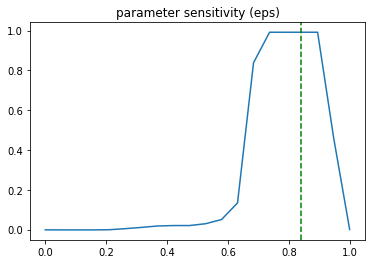

In [ ]:
parameter_sensitivity(X, laplacian_normalization='rw')

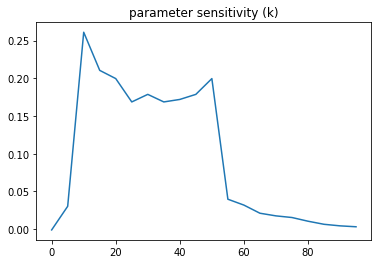

In [ ]:
parameter_sensitivity(X, parameter_type='k', laplacian_normalization='rw')

The sensitivity to the parameters $k$ and $\epsilon$ is about the same. We can see that on a short interval of values, we obtain good results and bad results on all the rest. We notice that we often get better results on $\epsilon$-graphs when we choose well the value of $\epsilon$. In particular, we see that the $\epsilon$ obtained by the minimum spanning tree algorithm is in the range of the epsilons giving very good results. On this interval, the results are roughly equivalent whereas it is not the case for the KNN-graphs, where the plateau is much less stable and the maximum value of sensitivity much lower.

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

In the case we cannot access "true" labels, we could use other evaluation metrics than the accuracy of the f1-score metrics.

Here are some metrics that could be used in this case :

*   **Silhouette Score** : this is a metric that calculates the mean intra-cluster distance $\mu_{intra}$ and the mean nearest-cluster distance for each sample $\mu_{inter}$. The coefficient is then computed as : $silhouette\_score = \frac{\mu_{inter} - \mu_{intra}}{\max(\mu_{inter}, \mu_{intra})}$. The score is only defined if the number of labels is between 2 and the number of samples minus 1. A high silhouette score indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters.

*   **Calinski-Harabasz Index *(or Variance Ratio Criterion)***: this is a score defined as ratio of the sum of between-cluster dispersion and of within-cluster dispersion : $score\_CH = \frac{(N-K)B}{(K-1)\sum_{k=1}^KW_k}$ where $W_k = \sum_{i\in I_k} ||\hat{x}_i-\mu_k||^2$, $\hat{x}_i$ the mean point of the cluster $k$, $I_k$ the set of indices of points belonging to the cluster $k$ and $B = \sum_{k=1}^K |I_k| ||\mu_k-\mu||^2$. A high Calinski-Harabasz Index indicates that the clustering solution is good.

*   **Davies-Bouldin Index** : this index measures the average similarity between each cluster and its most similar cluster. Better scores are got with clusters which are farther apart and less dispersed. Lower is the score, better are the results of the clustering.
The score is defined by : $score\_DB = \frac{1}{N} \sum_{i=1}^N \max_{j \ne i} R_{i,j}$ where $R_{i,j} = \frac{S_i + S_j}{M_{i,j}}$ and $S_i = \big(\frac{1}{T_i}\sum_{j=1}^{T_i} ||x_j - \hat{x}_i||_p^q\big)^{1/q}$ and $M_{i,j} = ||\hat{x}_i - \hat{x}_j||_p$.


There are other metrics like Dunn Index also that can be used and the choice of the metric depends on the dataset but the metrics that we must not use are those related to "true" labels such as accuracy and f1-score.





### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

For the image *four_elements*, it has been rather easy to segment the image with $ϵ$-graphs. Indeed, with the value of epsilon given by the minimum spanning tree method, the only parameter to be varied was the variance in the exponential distance when we build similarity graphs. With a to high variance, $var = 1$, the results were not good  enough, the four balls were not all distinguished but with a variance of $0.7$, I got very good result even if the the reflection on the balls (white color) was considered as belonging to the background that was also white. I tried the three laplacian normalization but all gave the same result.

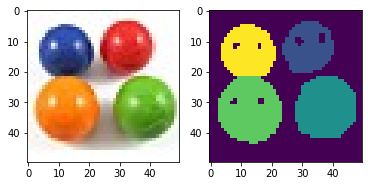

Getting good results for *fruit_salad* has been far more difficult, especially since the segmentation for $ϵ$-graphs took 1min30s and 15min for KNN-graphs.

Indeed, I did not manage to get good results with $ϵ$-graphs. Indeed, whatever the variance used to build graph similarity, this configuration of spectral clustering was able to detect the tail of the red apple (rather black)but detecting the pale green apple and orange slices in between was very difficult. Here are the best results I could get for 4 classes and then for 5 classes with $\epsilon$-graphs :

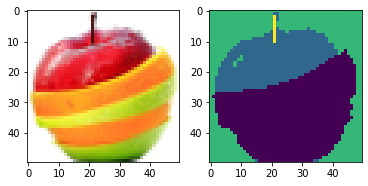

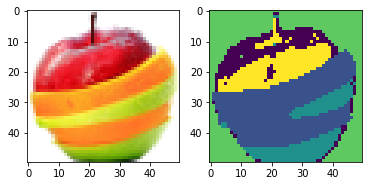

So I tried to use KNN-graphs and I got better results. Indeed, to choose the best value of $K$ (the number of neighbors), I computed for each $K$ in $[5,85]$ with a step of $5$ the silhouette score and I updated the best current $K$ when the silhouette score was higher than the previous best one. To compute the silhouette score, I did a K-Means clustering over the eigenvalues of the Laplacian matrix. The eigenvalues are still chosen as those associated with the $k$ (the number of clusters) first eigenvectors not constant. I also used the euclidean or the mahalanobis metric to compute the silhouette score, but it gives same results. I saw that here, the variance in the exponential distance when computing the similarity graph, does not really change things. 

One thing to note is that here, on the results given by KNN-graphs, the spectral clustering is unable to find the tail of the queue of the red apple, but it is much easier to detect the slices of pale green apple and orange that are in-between. This can be explained by the fact that the number of nodes that are in the class of the tail is much smaller than the number of nodes in the classe of the background, the red apple, the green apple and the orange, so the number of k-neighbors is much smaller, so the nodes of the tails are associated to the closer cluster which is the red apple cluster. We can see that, if we are not interested in the tail, the best result I got was for $4$ classes with a variance of $1$ and $K$ (the number of neighbors) equals to $50$. With $5$ classes, the results are not so good anymore, and I did not manage to find better results than the second result below.

Here : $K=50$, $num\_classes =4$ $var=1$, $metric=euclidean$ \\
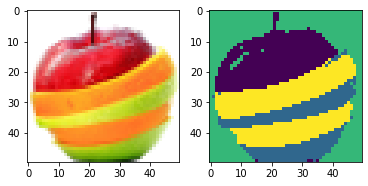

Here : $K=65$, $var=1$, $num\_classes=5$, $metric=euclidean$ \\
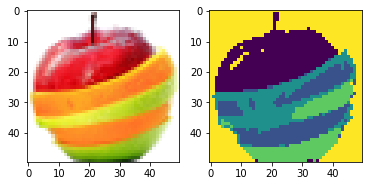

Here : $K=65$, $var=0.8$, $num\_classes=5$, $metric=euclidean$ : \\
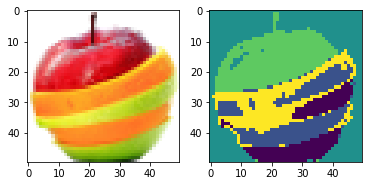

Here : $K=55$, $var=1$, $num\_classes=5$, $metric=mahalanobis$ : \\
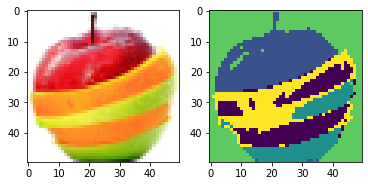

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

There are several things that are computationally and occupationally costly :

*   The way we are building our similarity matrix : the computation is in $O(n^2)$ where $n$ is the number of nodes. When $n$ is very large, like in a real photo we cannot keep this way of computation. There is also a computational issue with the computation of the nearest neighbors when we want to use $k>0$, because it implies computing the distance to all points from a given point, which is very expensive.
*   When computing the similarity matrix, we need to store all the information of the nodes and edges and here, we do that with a numpy array. With $n$ very large we cannot dot that anymore.
*   The computation of eigenvectors and eigenvalues that is computationally expensive. We need to find another way of computing it.



Here are what I would do to reduce the computational and occupational cost of Spectral Clustering :

*   To fight against the occupational cost, we need to reduce the dimensionality of the dataset by using sparse graph representations with *scipy.sparse* and also *COO* and *CSR* library.

*   We could use parallel computing with GPU in order to speed to computation of distances.

*   Concerning the cost of computing the eigenvectors and eigenvalues, we need to use approximate eigenvalue computation techniques. To do that, we can use the **QR Iteration** algorithm which is an iterative technique that enables to approximate simultaneously all the eigenvalues of a given matrix. Here we want to reduce the Laplacian matrix $L$. The idea is to transform $L$ by means of suitable similarity transformations into a form for which the calculation of the eigenvalues is easier than on the starting matrix. It uses the Schur decomposition of the matrix $L$ but as this decomposition cannot be determined directly because of the Abel's theorem, we use the QR iteration method based on the QR factorization. Here is the method :


> **QR Iteration algorithm :** \
$A_0 = L$, $T^{(0)}=(Q^{(0)})^TLQ^{(0)}$, $Q^{(0)}$ an othogonal matrix \
For $k=1,2,... :$ \
1. Determine $Q^{(k)}$, $R^{(k)}$ such that (QR factorization) : $$Q^{(k)}R^{(k)} = T^{(k-1)}$$
2. Take : $T^{(k)} = R^{(k)}Q^{(k)}$

At each step $k\geq1$, $T^{(k)} = R^{(k)}Q^{(k)} = (Q^{(0)}...Q^{(k)})^TL(Q^{(0)}...Q^{(k)})$, ie $T^{(k)}$ is orthogonally similar to $L$. For more details, see https://math.unice.fr/~frapetti/CorsoF/cours4part2.pdf. \
Some variant can be more efficient computationally as the *Golub-Kahan-Reinsch algorithm* which starts with reducing a general matrix into a bidiagonal one. This method is implemented in the LAPACK library with the subroutine DBDSQR.


### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

I did not manage to have results since I did not manage to reduce the complexity of the similarity matrix. Indeed, I tried


In [18]:
from scipy.sparse import coo_matrix
from scipy.linalg.lapack import dgesvd
from scipy.sparse import csr_matrix
from scipy.sparse import vstack

In [59]:
import torch
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Shape of the image :  (245025, 3)


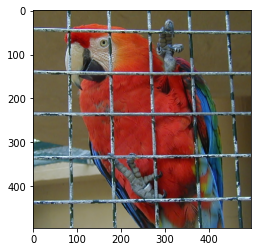

In [11]:
X = io.imread('/content/parrot.bmp')
X = (X - np.min(X)) / (np.max(X) - np.min(X))
plt.imshow(X)

im_side = np.size(X, 1)
Xr = X.reshape(im_side ** 2, 3)
print('Shape of the image : ', Xr.shape)

In [62]:
def exp_distance_indices(sparse_X, i, var, eps, device):
    distances = torch.exp(torch.Tensor(-(sparse_X.toarray() - sparse_X[i].toarray()) @ (sparse_X.toarray() - sparse_X[i].toarray()).transpose()/(2*var))).to(device)
    dist = csr_matrix(distances.detach().cpu().numpy()*(distances.detach().cpu().numpy() <= eps))
    return dist, [i for _ in range(dist.shape[0])], list(np.where(distances.detach().cpu().numpy() <= eps)[0])

def similarity_graph(X, var=1, eps=0.5, device=device):
    sparse_X = csr_matrix(X)
    n = X.shape[0]
    row, col = [], []
    data = csr_matrix([])
    for i in tqdm(range(n)):
        dist, row_indices, col_indices = exp_distance_indices(sparse_X, i, var, eps, device)
        row += row_indices
        col += col_indices
        print('dist', dist)
        print('row', row_indices)
        print('col', col_indices)
        if i==0:
            data = dist
        else :
            data = scipy.sparse.vstack((data, dist), format='csr')
    
    return csr_matrix((data, (row, col)), shape=(n, n))

In [ ]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    L = csr_matrix(W.shape)
    boolean_W = (W> 0)
    degrees = np.sum(boolean_W, axis=1)
    D = csr_matrix.diagonal(degrees)
    if laplacian_normalization=='unn':
        L= D-W
    if laplacian_normalization=='sym':
        normW = np.diag(np.power(degrees, -0.5)) @ W @ np.diag(np.power(degrees, -0.5))
        L = np.eye(W.shape[0]) - normW
    if laplacian_normalization=='rw':
        normW = scipy.linalg.inv(D) @ W
        L = L = np.eye(W.shape[0]) - normW

    
    # for example (unnormalized): L = D - W
    return scipy.sparse.coo_matrix(L)

In [42]:
def spectral_clustering(L, chosen_eig_indices=None, parameter_type='eps', num_classes=None):
    """
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    if chosen_eig_indices==None:
        G = nx.from_numpy_matrix(L)
        n_components = nx.number_connected_components(G)
        if n_components < num_classes :
            chosen_eig_indices = np.arange(n_components, num_classes)
        else :
            chosen_eig_indices = np.arange(1, num_classes)

    E, U  = dgesvd(L)
    indices = np.argsort(E)
    E = E[indices]
    U = U[:,indices]
    U = U.real
    E = scipy.sparse.coo_matrix.diagonal(E)
    U_cut = U[:,chosen_eig_indices]

    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    km = KMeans(num_classes).fit(U_cut)
    Y = km.labels_
    return Y